# CS470 Introduction to Artificial Intelligence
## Deep Learning Practice 
#### TA. Minho Sim


---

## 2-2. Text classification using IMDB dataset

#### Topics for this chapter
 * IMDB datset
 * One-hot Encoding
 * Overfitting
---

#### IMDB dataset

The IMDB dataset is data that contains movie review comments and positive or negative label representing the evaluation of the audience. This contains the text comments for 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These data are splited in half so that we can get 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are balanced and unbiased, which means they contain an equal number of positive and negative reviews.

#### Importance of balanced dataset
Let's assume that we have 9,999 positive reviews and 1 negative review. Without any training, we can get 99.99% accuracy by just predicting all reviews as positive. This situation is called the _Accuracy Paradox_. Since we're using accuracy as a model metric, it's important to **balance the dataset well**. In the case of MNIST dataset, we can say that the dataset is balanced when we have about 60,000/10=6,000 images per digit class. (60,000 is the total number of images and 10 is the number of class)

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
print('Tensorflow: ', tf.__version__)

import numpy as np
import matplotlib.pyplot as plt

Tensorflow:  2.6.0


To handle the text dataset, we first need to transform the data into a form that can be used for training. There are two common methods we can use when dealing with text data, **one-hot encoding** and **word embedding**. In this practice, we'll use one-hot encoding method (Word embedding will be covered later in the RNN part). Before using one-hot encoding, let's take a quick look at what one-hot encoding is.

<img src="https://github.com/keai-kaist/CS470-2021-2/blob/main/Lab1/Sep%209/images/one_vs_we.png?raw=true" width=1000>
<br/><br/>

#### One-hot encoding
One-hot encoding is a vector representation of sentences. It has the **vector dimension as the size of the word set** and **1 is assigned to the index of the word to be expressed / 0 is assigned to the other index**. The detailed procedure of one-hot encoding is as follows.

(1) Give each word an unique index.

(2) 1 is assigned to the index of the word to be expressed, and 0 is assigned otherwise.

<br/>
I will explain this method with simple example.
<br/>
Let's assume that we have a word dictionary that contains 7 words, 'today' ,'I' ,'was' ,'studied' ,'happy' ,'math' ,'not'. We can map these words to integers 0-6. 

<br/>
<img src="https://github.com/keai-kaist/CS470-2021-2/blob/main/Lab1/Sep%209/images/onehot.png?raw=true" width=300>
<br/>

Now, we can represent sentences consisting of words from the dictionary. 

For example, a sentence 'I studied math today' can be represented as [0, 1, 3, 5] (not considering the order).
If we make a vector that has the vector dimension as the size of the dictionary, we get a vector as below.

<img src="https://github.com/keai-kaist/CS470-2021-2/blob/main/Lab1/Sep%209/images/empty.png?raw=true" width=300>

After assining 1 to the index of the words in the original list ([0, 1, 3, 5]), we get one-hot encoded vector as below.

<img src="https://github.com/keai-kaist/CS470-2021-2/blob/main/Lab1/Sep%209/images/convert.png?raw=true" width=300>

#### Limitation of One-hot encoding
One-hot encoding has the disadvantage that if the number of words increases, the space required to store the vector increases too. If we have 10,000 words that we want to express, regardless of the length of the sentence to be expressed, a vector of length 10,000 is required. (even for a sentence that contains only one word.)

Also, the one-hot vector encoding cannot express the similarity of words. Assume that we have 4 words 'wolf', 'dog', 'tiger', 'chair'. We can consider 'wolf', 'dog', 'tiger' have semantically similar context since they are all animals and 'chair' is less similar to the previous three words. In one-hot encoding, since inner-product similarity between two different words is always 0 and Euclidean distance between them is always $\sqrt{2}$, there is no way to express the degree of similarity between words.

Despite these shortcomings, one-hot encoding is easy to understand and use. Another reason for using the one-hot encding method is to check the overfitting problem in next practice. Therefore in this practice, we will use one-hot encoding.
Let's first download the IMDB dataset:

In [2]:
NUM_WORDS = 10000
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.imdb.load_data(num_words=NUM_WORDS)

17473536/17464789 [==============================] - 2s 0us/step


The argument num_words=10000 keeps the top 10,000 most frequently occurring words in the training data. The rare words are discarded to keep the size of the data manageable.

Let's take a moment to understand the format of the data.

In [3]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))
print("Train data[0]: {}. \nlabel[0]: {}".format(train_data[0], train_labels[0]))

Training entries: 25000, labels: 25000
Train data[0]: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]. 
labe

The dataset comes preprocessed: each example is an array of integers representing the words of the movie review. Each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

From each data, we'll create an ont-hot encodering vector with a 10,000-dimension

In [4]:
def multi_hot_sequences(sequences, dimension):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # set specific indices of results[i] to 1s
    return results

NUM_WORDS = 10000

train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)

In [5]:
print("Train data[0]: {}. \nlabel[0]: {}".format(train_data[0], train_labels[0]))

Train data[0]: [0. 1. 1. ... 0. 0. 0.]. 
label[0]: 1


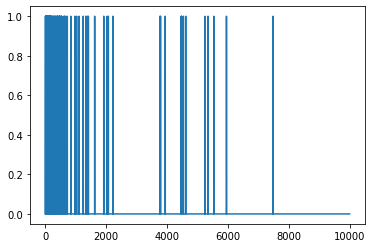

In [6]:
plt.plot(train_data[0])

#### Build model

Similar to previous model, we'll define a simple model using the [`tf.keras.layers.Dense`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Dense) layer.

In [13]:
# TODO: define a sequential model
model = tf.keras.Sequential([
    # TODO: add a first dense layer with 16 nodes applying ReLU activation function
    tf.keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)),
    # TODO: add a second dense layer with 16 nodes applying ReLU activation function
    tf.keras.layers.Dense(16, activation='relu'),
    # TODO: add a last dense layer with only 1 node applying Softmax activation function
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [14]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


#### Compile the model

After defining the model structure, we configure the model such as optimizer, loss and metrics for training. We will use loss function as `binary_crossentropy` which is popular for binary classification problem.

In [15]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

#### Create a validation set

When training, we want to check the accuracy of the model on data it hasn't seen before. So we will create a **validation set** by setting apart 10,000 examples from the original training data. The reason that we do not use the testing set now is our goal is to develop and tune our model using only the training data and then use the test data just once to evaluate our accuracy. Splitting whole data into three sub-data (training/validation/test) is very common.

In [16]:
# First 10,000 elements of train_data
x_val = train_data[:10000]

# Rest elements of train_data
partial_x_train =train_data[10000:]


# First 10,000 elements of train_labels
y_val = train_labels[:10000]

# Rest elements of train_labels
partial_y_train =train_labels[10000:]

#### Train the model

Then, we'll start to train the model.

In [17]:
# Define the batch size and the number of epochs to use during training
BATCH_SIZE = 512
EPOCHS = 20

In [19]:
# TODO: train the model using (train_images, train_labels). 
#       do not forget to set epochs and batch size as the parameters!
model_history = model.fit(partial_x_train,
                          partial_y_train,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=(x_val, y_val),
                          verbose=1)

Epoch 1/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0029 - accuracy: 0.9999 - val_loss: 0.6688 - val_accuracy: 0.8669
Epoch 2/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0026 - accuracy: 0.9999 - val_loss: 0.6822 - val_accuracy: 0.8674
Epoch 3/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0023 - accuracy: 0.9999 - val_loss: 0.6957 - val_accuracy: 0.8667
Epoch 4/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.7083 - val_accuracy: 0.8666
Epoch 5/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.7198 - val_accuracy: 0.8663
Epoch 6/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.7321 - val_accuracy: 0.8661
Epoch 7/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.7433 - val_accuracy: 0.8666
Epoch 8/20
30

With this approach our model reaches a validation accuracy of around 88% (note the model is overfitting, training accuracy is significantly higher).

#### Evaluate the model
And let's see how the model performs. Two values will be returned, loss (a number that represents our error, lower values are better) and accuracy (higher values are better).

In [20]:
results = model.evaluate(test_data, test_labels, verbose=0)

print(results)

[0.9281803369522095, 0.8532400131225586]


This fairly naive approach achieves an accuracy of about 85%.

#### Plotting network performance trend
Again let's plot the trend of loss and accuracy of our model.

In [21]:
history_dict = model_history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

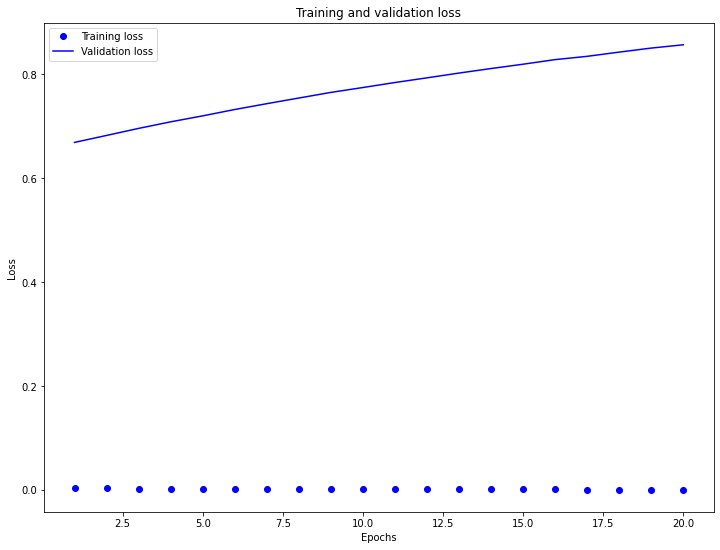

C:\Users\swoo\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.


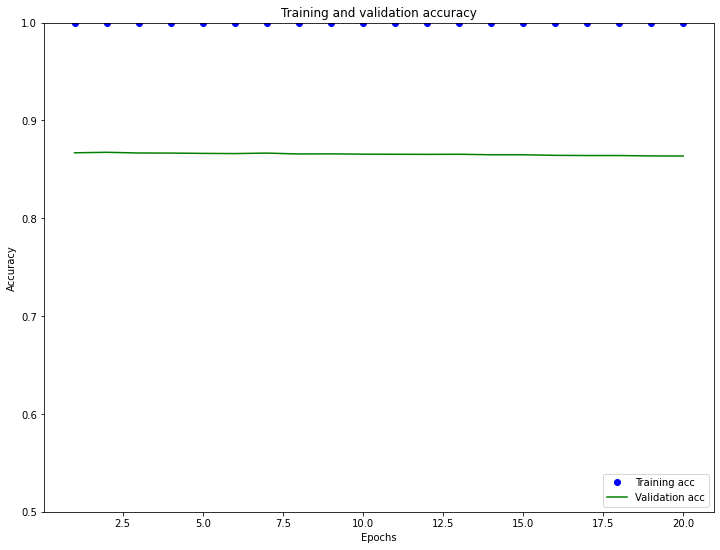

In [22]:
history_dict = model_history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc',color='green')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice that the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected result when using a gradient descent optimization—based method. It will minimize the loss function value on every iteration.

However, this isn't the case for the validation loss and accuracy. Validation accuracy seems to peak after about very few epochs and validation loss goes up after that point. This is an example of **_overfitting_: the model performs better on the training data than it does on data it has never seen before.** After this point, the model over-optimized and learned representations specific to the training data that do not generalize to test data.

To cope with this situation, we can prevent overfitting by simply stopping the training after few epochs. And in the next practice, we will learn some techniques to prevent overfitting and make model with generality.